In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm , cauchy
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
plt.style.use('dark_background')

# SI units

k_b = 1.380649 * 10**(-23)  #(J/K)
epsilon = 120 * k_b         #(joule)
sigma = 0.34 * 10**(-9)     #(m)
m = 6.634 * 10**(-26)       #(kg)

### Exercise 07.1

In [2]:
p = np.loadtxt( "MonteCarlo_NVT/liquid/pressures.0" , dtype=float , usecols=(0) , unpack= True)
u = np.loadtxt( "MonteCarlo_NVT/liquid/energy.0" , dtype=float , usecols=(0) , unpack= True)
p_solid = np.loadtxt( "MonteCarlo_NVT/solid/pressures.0" , dtype=float , usecols=(0) , unpack= True)
u_solid = np.loadtxt( "MonteCarlo_NVT/solid/energy.0" , dtype=float , usecols=(0) , unpack= True)
p_gas = np.loadtxt( "MonteCarlo_NVT/gas/pressures.0" , dtype=float , usecols=(0) , unpack= True)
u_gas = np.loadtxt( "MonteCarlo_NVT/gas/energy.0" , dtype=float , usecols=(0) , unpack= True)

In [9]:
# define autocorrelation

def autocorrelation_t(press, t, t_max):
    
    # sum of products
    sum1 = 0
    for t_primo in range(t_max-t):
        sum1 = sum1 + press[t_primo]*press[t_primo+t]
    
    # sum in t'
    sum2 = 0
    for t_primo in range(t_max-t):
        sum2 = sum2 + press[t_primo]
        
    # sum in t'+t
    sum3 = 0
    for t_primo in range(t_max-t):
        sum3 = sum3 + press[t_primo+t]
     
    # normalization - sum of squares in t'
    sum4 = 0
    for t_primo in range(t_max):
        sum4 = sum4 + press[t_primo]**2
      
    # normalization - sum in t'
    sum5 = 0
    for t_primo in range(t_max):
        sum5 = sum5 + press[t_primo]
    
    num = 1./(t_max-t) * sum1 - (1./(t_max-t) * sum2) * (1./(t_max-t) * sum3)
        
    den = 1./t_max * sum4 - (1./t_max * sum5)**2
    
    return num / den

def autocorrelation(press, t_max):
    
    ac = []
    for t in range(t_max):
        ac.append(autocorrelation_t(press, t, t_max))
        
    return ac

In [10]:
# define system

phases = ['solid', 'liquid', 'gas']
npart = 108

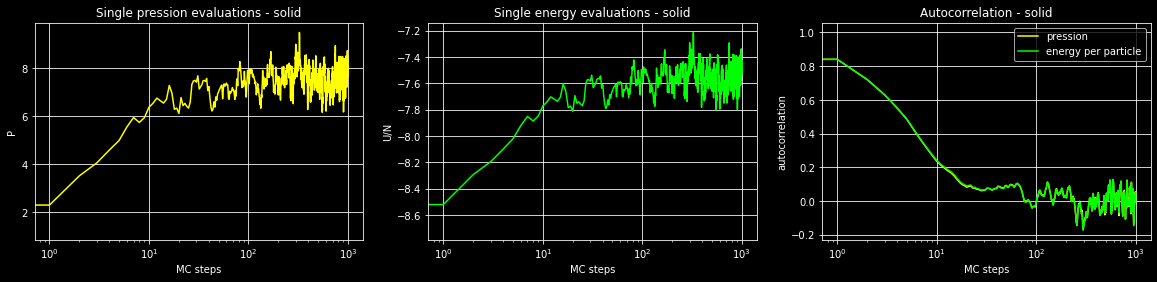

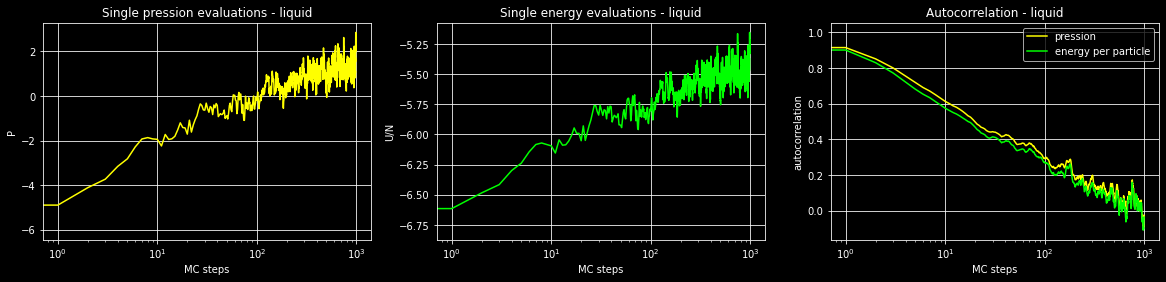

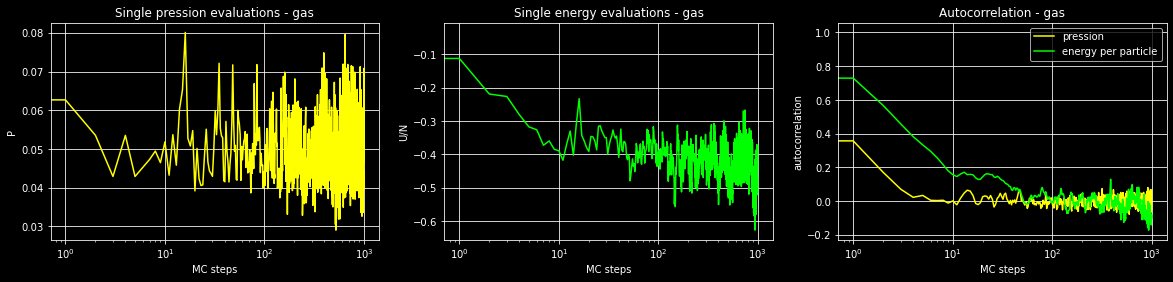

In [22]:
# plot 

t_max = 2000

for phase in phases:
    
    press = np.genfromtxt("MonteCarlo_NVT/"+phase+"/pressures.0", dtype=float)
    ene = np.genfromtxt("MonteCarlo_NVT/"+phase+"/energy.0", dtype=float)
    
    ac_p = autocorrelation(press, t_max)
    ac_e = autocorrelation(ene, t_max)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))

    ax[0].plot(press[:1000], color='yellow')
    ax[0].set_title("Single pression evaluations - "+phase)
    ax[0].set_xlabel("MC steps")
    ax[0].set_ylabel("P")
    ax[0].set_xscale('log')
    ax[0].grid()
    
    ax[1].plot(ene[:1000], color='#00FF00')
    ax[1].set_title("Single energy evaluations - "+phase)
    ax[1].set_xlabel("MC steps")
    ax[1].set_ylabel("U/N")
    ax[1].set_xscale('log')
    ax[1].grid()

    ax[2].plot(ac_p[:1000], label='pression', color='yellow')
    ax[2].plot(ac_e[:1000], label='energy per particle', color='#00FF00')
    ax[2].set_title("Autocorrelation - "+phase)
    ax[2].set_xlabel("MC steps")
    ax[2].set_ylabel("autocorrelation")
    ax[2].set_xscale('log')
    ax[2].legend()
    ax[2].grid()

The graphs above show single evaluations of pressure and energy per particle of a molecular system made of 108 particles, in solid, liquid and gas phase and their autocorrelations as a function of the MC steps.
    
From the first two plots of each row, we can see that there is an equilibration of the system in all phases, but at different points, between 100 and 1000 steps per block.

The autocorrelation has a similar trend: for the solid and liquid phase, around 100 steps are required to decorrelate the blocks, while the gas only requires around 20. This could be due to the fact that a gas is naturally a less correlated system or also to the fact that for the gas phase much larger MC movement step were used to reach 50% acceptance (which was not reached by the way, only around 65% with a step of 2.5) and therefore it is easier for the system to quickly get to new different configurations. The step for the solid state was set to 0.12 and for the liquid to 0.2 and this explains the slower decay of their correlation.
    
In all 3 cases we can say that blocks of more than 1000 steps are assured to have lost all correlation. </span>

# Statistical uncertainties

In [12]:
L = [10, 20, 50, 100, 200, 500, 1000, 1500, 2000, 3000, 3500, 4000, 4500, 5000]  # length of block
M = 500000    # total steps

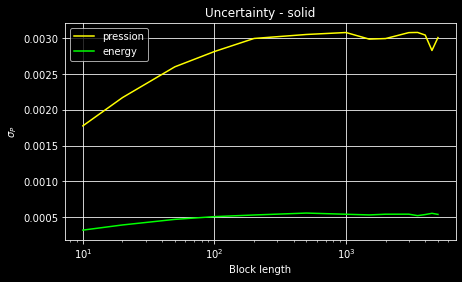

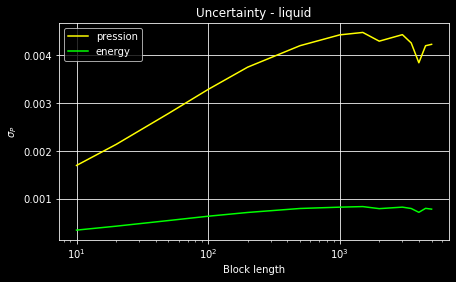

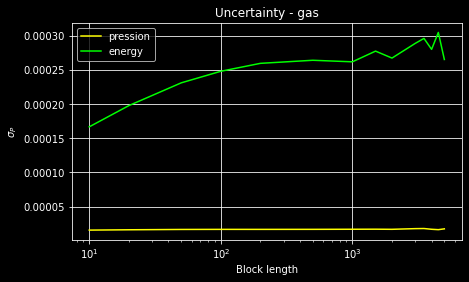

In [53]:
def error(ave, ave2, iblk):
    if iblk == 0:
        return 0.
    else:
        return np.sqrt((ave2[iblk]-ave[iblk]**2)/iblk)
    
for phase in phases:
    
    err_press = []
    err_ene = []

    press = np.genfromtxt("MonteCarlo_NVT/"+phase+"/pressures.0", dtype=float)
    ene = np.genfromtxt("MonteCarlo_NVT/"+phase+"/energy.0", dtype=float)
    
    #press = press*epsilon/(sigma**3)
    #ene = ene*epsilon

    for l in L:

        N = int(M/l)  # number of blocks

        err_p = np.zeros(N)
        ave_p = np.zeros(N)
        ave2_p = np.zeros(N)
        err_e = np.zeros(N)
        ave_e = np.zeros(N)
        ave2_e = np.zeros(N)

        for i in range(N):

            s_p = 0.
            s_e = 0.
            for j in range(l):
                s_p += press[j + l*i]
                s_e += ene[j + l*i]
            s_p /= l
            s_e /= l

            if i == 0:
                ave_p[i] = s_p
                ave2_p[i] = s_p**2
                ave_e[i] = s_e
                ave2_e[i] = s_e**2
            else:
                ave_p[i] = (ave_p[i-1] + s_p)
                ave2_p[i] = (ave2_p[i-1] + s_p**2)
                ave_e[i] = (ave_e[i-1] + s_e)
                ave2_e[i] = (ave2_e[i-1] + s_e**2)

        for i in range(N):

            ave_p[i] = ave_p[i] / (i+1)
            ave2_p[i] = ave2_p[i] / (i+1)
            err_p[i] = error(ave_p, ave2_p, i)
            ave_e[i] = ave_e[i] / (i+1)
            ave2_e[i] = ave2_e[i] / (i+1)
            err_e[i] = error(ave_e, ave2_e, i)

        err_press.append(err_p[-1])
        err_ene.append(err_e[-1])
        
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    ax.plot(L, err_press, color='yellow', label='pression')
    ax.plot(L, err_ene, color='#00FF00', label='energy')
    ax.set_title("Uncertainty - "+phase)
    ax.set_xlabel("Block length")
    ax.set_ylabel(r'$\sigma_P$')
    ax.set_xscale('log')
    ax.grid()
    ax.legend()

Statistical uncertainty grows as a function of the size of the blocks. The trend is completely compatible with the expected one, in fact in too small blocks the measurements are very correlated and the statistical uncertainty is underestimated. On the other hand, as the size of the blocks increases, the uncertainty increases until it becomes saturated. When this happens the measurements are now uncorrelated, so the block size has been chosen correctly. It is also clear that it is useless to make blocks that are too large, in all three systems the uncertainties are already saturated with 1000 steps per block.

# Esercizio 7.2 - <span style="color:blue"> $ g(r) $ pair distribution function  </span>

In [15]:
# read data

g_solid = np.genfromtxt("MonteCarlo_NVT/solid/output.gave.0", dtype=float, delimiter=',')
g_liquid = np.genfromtxt("MonteCarlo_NVT/liquid/output.gave.0", dtype=float, delimiter=',')
g_gas = np.genfromtxt("MonteCarlo_NVT/gas/output.gave.0", dtype=float, delimiter=',')

In [16]:
rho = {"solid": 1.1, "liquid": 0.8, "gas": 0.05}  # densities
box = {"solid": 0., "liquid": 0., "gas": 0.}

for phase in phases:
    vol = npart/rho[phase]
    box[phase] = vol**(1./3.)

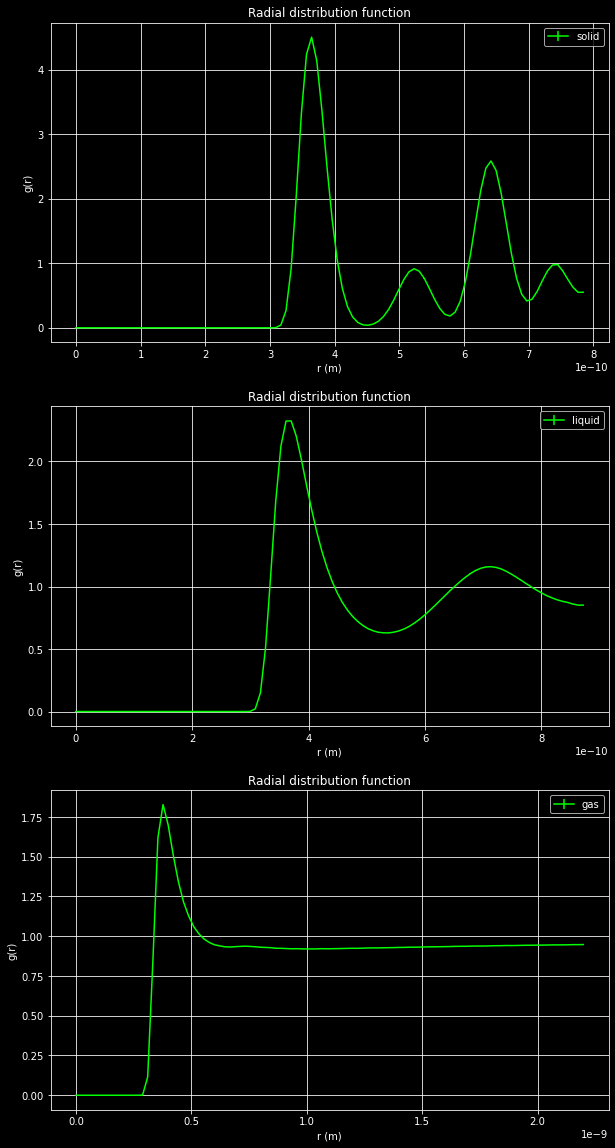

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

ax[0].errorbar(x=np.linspace(0, box["solid"]/2, 100)*sigma, y=g_solid[:,0], yerr=g_solid[:,1], label="solid",color='#00FF00')
ax[1].errorbar(x=np.linspace(0, box["liquid"]/2, 100)*sigma, y=g_liquid[:,0], yerr=g_liquid[:,1], label="liquid",color='#00FF00')
ax[2].errorbar(x=np.linspace(0, box["gas"]/2, 100)*sigma, y=g_gas[:,0], yerr=g_gas[:,1], label="gas",color='#00FF00')
for x in ax:
    x.set_title("Radial distribution function")
    x.set_xlabel("r (m)")
    x.set_ylabel("g(r)")
    x.legend()
    x.grid()

The graphs above show the radial distribution function g(r) for a couple of particles for solid, liquid, and gas Argon. The 3 systems were simulated with a MC NVT algorithm (canonic ensemble) of 100000 MC steps with 50 blocks, each of length 2000.

The resulting curves look plausible:
- in the solid one should expect spatial periodicity, indeed the curve shows a peak for the nearest neighbors and other regularly spaced peaks as the distance r between the 2 particles of the couple increases, that is as we travel the lattice.
- in the liquid system there is a clear peak just before $4Å$, and after that there are smoother peaks at larger distances.
- in the gas the interparticle distance still presents a peak of nearest neighbors, but after that the particle has neighbors at all distances without a specific periodicity like the solid.


# Esercizio 7.3 - <span style="color:blue"> $g(r)$ in NVE ensemble  </span>

In [27]:
g_solid, error_g_solid =  np.loadtxt( "MolecularDynamics_NVE/solid/ave_gofr.dat" , dtype=float , delimiter=',' , usecols=(0 , 1) , unpack= True)
g_liquid, error_g_liquid =  np.loadtxt( "MolecularDynamics_NVE/liquid/ave_gofr.dat" , dtype=float , delimiter=',' , usecols=(0 , 1) , unpack= True)
g_gas, error_g_gas =  np.loadtxt( "MolecularDynamics_NVE/gas/ave_gofr.dat" , dtype=float , delimiter=',' , usecols=(0 , 1) , unpack= True)

In [29]:
binsize_liq = (108/0.8)**(1/3) /200.
bins_liq = np.arange( start = binsize_liq/2. , stop =  binsize_liq*(0.5 + 100), step = binsize_liq  )
binsize_sol = (108/1.1)**(1/3) /200.
bins_sol = np.arange( start = binsize_sol/2. , stop =  binsize_sol*(0.5 + 100), step = binsize_sol  )
binsize_gas = (108/0.05)**(1/3) /200.
bins_gas = np.linspace( start = binsize_gas/2. , stop =  binsize_gas*(0.5 + 100), num = 100) 

Text(0.5, 1.0, 'Pair distribution function for a gas')

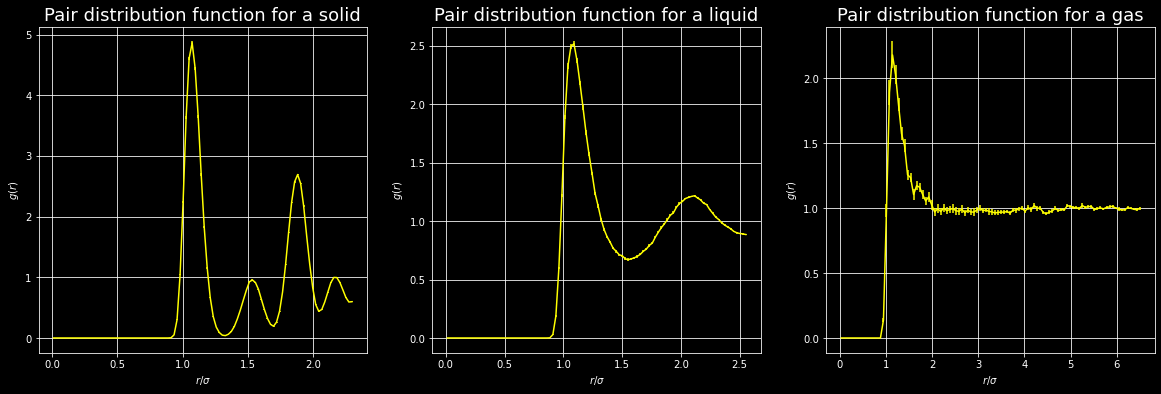

In [32]:
fig , [ax1 , ax2 , ax3] = plt.subplots( 1 , 3 , figsize = (20 , 6))
#solid
ax1.errorbar( bins_sol , g_solid , yerr = error_g_solid , color = "yellow")
ax1.set_xlabel(r'$r/ \sigma $')
ax1.set_ylabel(r'$g(r)$')
ax1.grid(True)
ax1.set_title('Pair distribution function for a solid' , fontsize=18 )
#liquid
ax2.errorbar( bins_liq , g_liquid , yerr = error_g_liquid , color = "yellow")
ax2.set_xlabel(r'$r/ \sigma $')
ax2.set_ylabel(r'$g(r)$')
ax2.grid(True)
ax2.set_title('Pair distribution function for a liquid' , fontsize=18 )
#gas
ax3.errorbar( bins_gas , g_gas , yerr = error_g_gas , color = "yellow")
ax3.set_xlabel(r'$r/ \sigma $')
ax3.set_ylabel(r'$g(r)$')
ax3.grid(True)
ax3.set_title('Pair distribution function for a gas' , fontsize=18 )

    The computation of the pairwise distribution functions in the molecular dynamics code was performed on balanced systems. The equilibration was done in a similar way to exercise 4:
    
         1. For the solid phase, 8 restarts were performed at a distance of 500 time steps
         2. The liquid system was balanced by performing 10 restarts at a distance of 500 steps
         3. The gas phase, on the other hand, was balanced with 20 restarts 500 steps apart

     After that the measurement of the properties is performed every 10 steps of a simulation with a total of 20000 steps. Data blocking on these measures was performed by dividing them into 20 blocks. The compatibility of these measures with those made in the canonical ensemble is evident, subsequently a direct comparison will be made.

# Esercizio 7.4 - <span style="color:blue"> Simulations for Argon in NVT ensemble </span> 

### Solid Phase

In [39]:
# read data
e_tot, err_e_tot = np.genfromtxt("MonteCarlo_NVT/solid/output.epot.0", dtype='float', unpack=True, usecols=(2,3))
p, err_p = np.genfromtxt("MonteCarlo_NVT/solid/output.pres.0", dtype='float', unpack=True, usecols=(2,3))
g, err_g = np.genfromtxt("MolecularDynamics_NVE/solid/ave_gofr.dat", dtype='float', delimiter=',', unpack=True)

# SI units
p *= epsilon/(sigma**3)
err_p *= epsilon/(sigma**3)
e_tot *= epsilon
err_e_tot *= epsilon

In [42]:
gr_liq , errors_liq = np.loadtxt( "MonteCarlo_NVT/liquid/output.gave.0" , dtype=float , delimiter=',' ,  usecols=(0 , 1) , unpack= True)
gr_sol , errors_sol = np.loadtxt( "MonteCarlo_NVT/solid/output.gave.0" , dtype=float , delimiter=',' , usecols=(0 , 1) , unpack= True)
gr_gas , errors_gas = np.loadtxt( "MonteCarlo_NVT/gas/output.gave.0" , dtype=float , delimiter=',' , usecols=(0 , 1) , unpack= True)

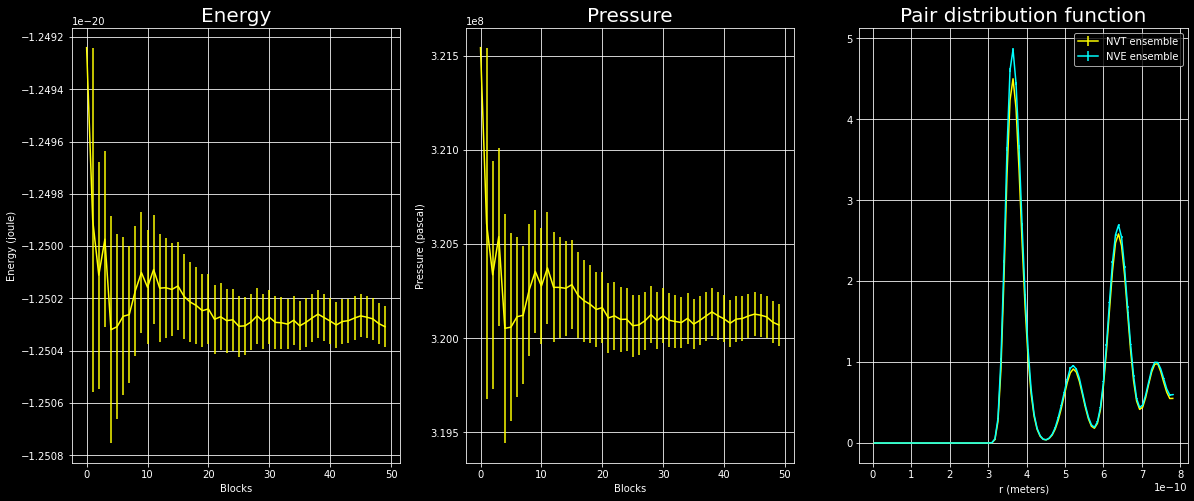

In [46]:
fig , ax = plt.subplots(1, 3 , figsize=(20,8)) 
#Potential energy
ax[0].errorbar( np.arange(len(energy_sol)) , energy_sol  , yerr= err_ene_sol, color = "yellow" )
ax[0].set_title("Energy" , fontsize=20)
ax[0].set_xlabel( "Blocks" )
ax[0].set_ylabel( "Energy (joule)" )
ax[0].grid()

#Pressures
ax[1].errorbar( np.arange(len(pres_sol)) , pres_sol  , yerr= err_pres_sol , color = "yellow" )
ax[1].set_title("Pressure" , fontsize=20)
ax[1].set_xlabel( "Blocks" )
ax[1].set_ylabel( "Pressure (pascal)" )
ax[1].grid()

#pair distribution function
ax[2].errorbar( bins_sol , gr_sol , yerr = errors_sol , color= "yellow" , label = "NVT ensemble")
ax[2].errorbar( bins_sol , g_solid , yerr = error_g_solid , color="#00FFFF" , label = "NVE ensemble")
ax[2].set_title("Pair distribution function" , fontsize=20)
ax[2].set_xlabel( "r (meters)" )
ax[2].legend(loc="best")
ax[2].grid()

The solid phase of argon was simulated at T = 96 K, $ \rho = 4.32 * 10 ^ {- 29} $ and with cut-off $ r = 7.48 * 10 ^ {- 10} $. The simulation foresees a total of $ 10 ^ 5 $ steps, divided into 50 blocks of length 2000. Energy and pressure are similar to those obtained in the microcanonical ensemble in exercise 4, verifying the fact that the ensembles are ultimately equivalent. Also the pairwise distribution functions find good agreement in the two thermodynamic ensembles.

### Liquid Phase

In [47]:
energy_liq , err_ene_liq = np.loadtxt( "MonteCarlo_NVT/liquid/output.epot.0" , dtype=float , delimiter=',' , usecols=(2,3) , unpack= True)
pres_liq , err_pres_liq = np.loadtxt( "MonteCarlo_NVT/liquid/output.pres.0" , dtype=float , delimiter=',' , usecols=(2,3) , unpack= True)

#SI UNITS
energy_liq *= epsilon 
err_ene_liq *= epsilon
pres_liq *= epsilon / (sigma_const**3)
err_pres_liq *= epsilon / (sigma_const**3)
bins_liq *= sigma_const

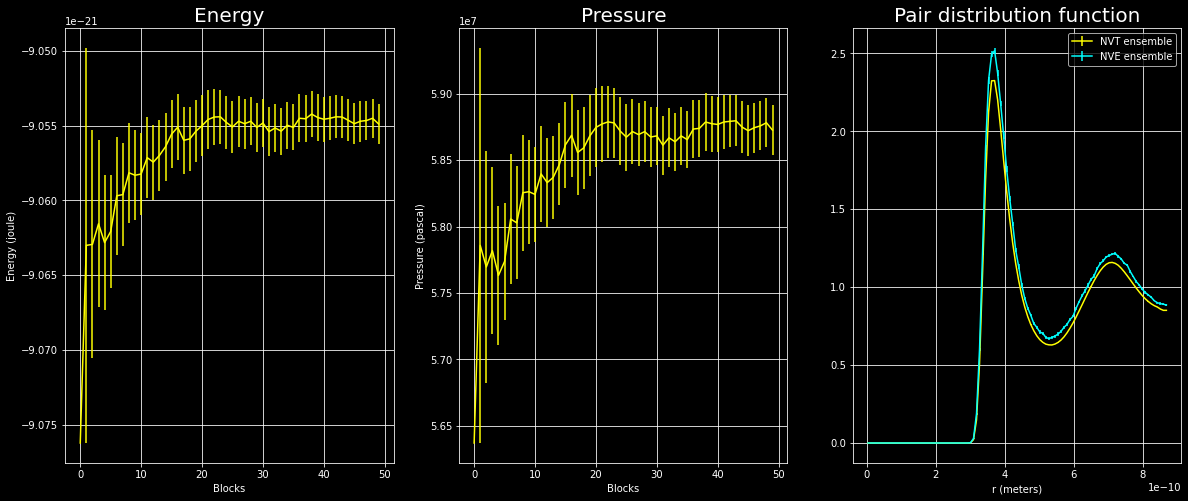

In [49]:
fig , ax = plt.subplots(1, 3 , figsize=(20,8)) 
#Energy
ax[0].errorbar( np.arange(len(energy_liq)) , energy_liq  , yerr= err_ene_liq , color = "yellow")
ax[0].set_title("Energy" , fontsize=20)
ax[0].set_xlabel( "Blocks" )
ax[0].set_ylabel( "Energy (joule)" )
ax[0].grid()

#Pressure
ax[1].errorbar( np.arange(len(pres_liq)) , pres_liq  , yerr= err_pres_liq , color = "yellow")
ax[1].set_title("Pressure" , fontsize=20)
ax[1].set_xlabel( "Blocks" )
ax[1].set_ylabel( "Pressure (pascal)" )
ax[1].grid()

#g(r)
ax[2].errorbar( bins_liq , gr_liq , yerr = errors_liq , color = "yellow" , label = "NVT ensemble")
ax[2].errorbar( bins_liq , g_liquid , yerr = error_g_liquid , color="#00FFFF" , label = "NVE ensemble")
ax[2].set_title("Pair distribution function" , fontsize=20)
ax[2].set_xlabel( "r (meters)" )
ax[2].legend(loc="best")
ax[2].grid()

The liquid phase of argon was simulated at T = 132 K, $ \rho = 3.14 * 10 ^ {- 29} $ and with cut-off $ r = 8.5 \times 10 ^ {- 10} $. Energy and pressure are similar to those obtained in the microcanonical ensemble in exercise 4, verifying the fact that the ensembles are ultimately equivalent. Also the pairwise distribution functions find good agreement in the two thermodynamic ensembles.

### Gas phase

In [50]:
energy_gas, err_ene_gas = np.loadtxt( "MonteCarlo_NVT/gas/output.epot.0" , dtype=float , delimiter=',' , usecols=(2,3) , unpack= True)
pres_gas , err_pres_gas = np.loadtxt( "MonteCarlo_NVT/gas/output.pres.0" , dtype=float , delimiter=',' , usecols=(2,3) , unpack= True)

#SI UNITS
energy_gas *= epsilon 
err_ene_gas *= epsilon
pres_gas *= epsilon / (sigma_const**3)
err_pres_gas *= epsilon / (sigma_const**3)
bins_gas *= sigma_const

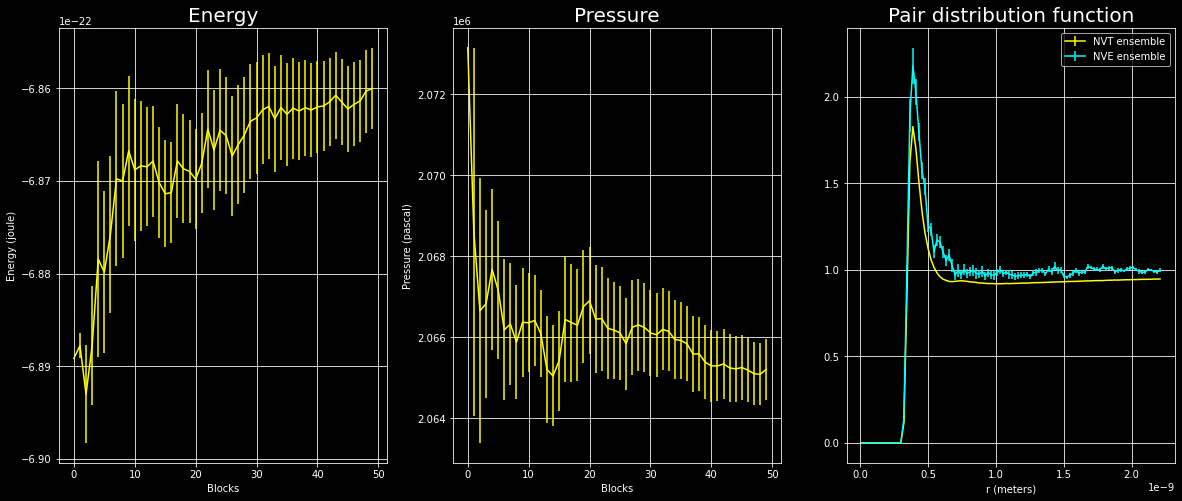

In [52]:
fig , ax = plt.subplots(1, 3 , figsize=(20,8)) 
#energy
ax[0].errorbar( np.arange(len(energy_gas)) , energy_gas  , yerr= err_ene_gas , color = "yellow")
ax[0].set_title("Energy" , fontsize=20)
ax[0].set_xlabel( "Blocks" )
ax[0].set_ylabel( "Energy (joule)" )
ax[0].grid()

#pressure
ax[1].errorbar( np.arange(len(pres_gas)) , pres_gas  , yerr= err_pres_gas , color = "yellow")
ax[1].set_title("Pressure" , fontsize=20)
ax[1].set_xlabel( "Blocks" )
ax[1].set_ylabel( "Pressure (pascal)" )
ax[1].grid()

#g(r)
ax[2].errorbar( bins_gas , gr_gas , yerr = errors_gas , color = "yellow" , label ="NVT ensemble")
ax[2].errorbar( bins_gas , g_gas , yerr = error_g_gas , color="#00FFFF" , label = "NVE ensemble" )
ax[2].set_title("Pair distribution function" , fontsize=20)
ax[2].set_xlabel( "r (meters)" )
ax[2].legend(loc="best")
ax[2].grid()

La fase gassosa dell'argon è stata simulata a T = 144 K, $\rho = 1.96 * 10^{-30}$ e con cut-off $r = 1.7 \times 10^{-9}$. Energia e pressione risultano simili a quelle ottenute nell'ensemble microcanonico dell'esercizio 4, a verifica del fatto che gli ensemble sono alla fine equivalenti. Anche le funzioni di distribuzione a coppie trovano buon accordo nei due ensemble termodinamici.

### Final comments

The Monte Carlo simulations in the canonical assembly were performed with a total of $ 10^5 $ steps, divided into 50 blocks of 2000 steps each - These values were chosen keeping in mind the results of the first part of this notebook, in which we calculated the length of the blocks needed to eliminate correlations.

The pressure results are consistent with the physics of the system and compatible with the values obtained in the notebook 4, where we calculated them in the microcanonical ensemble. The pressure in a solid is the most intense, the intermediate case is that of a liquid and finally the pressure is lower for gases.

The potential energies also take on plausible values: the energy is more intense for the solid, which is the most strongly interacting system. The lower potential is calculated in the case of the gas, which is actually the system with the fewest interactions.

Comparison of the radial distribution functions show good agreement between the two algorithms, albeit with some differences. In particular, the Verlet algorithm leads to a greater error on the data. This happens because the Verlet algorithm is more unstable, in the sense that it struggles to maintain the simulation temperature and therefore cannot be performed with a number of moves comparable to those performed in the monte carlo algorithm, because the discretization error given from the integration of the equations of motion it propagates too fast. Despite the lower number of steps, the agreement between the functions produced is good.

### <span style="color:purple"> Conversion from Lennard-Jones units to SI units: 

<span style="color:purple">
    
    
- multiply lengths by $\sigma$: $ r = \sigma r^* $
- multiply temperature by $ \frac{\epsilon} { k_{b}} $  : $ T = T^* \frac{\epsilon} { k_{b}} $
- multiply energies by $\epsilon$: $ E = E^* \epsilon $
- multiply time by $  \sqrt ( \frac {m \sigma^2}{ \epsilon} ) $

For the simulated Argon system:
- $\sigma = 0.34 nm$
- $ \frac{\epsilon} { k_{b}} = 120 K$
- $ m = 39,948 u$ 